<a href="https://colab.research.google.com/github/Marcosuff/Marcosuff.github.io/blob/master/nbs/Graph_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#export
%%capture
import sys
!pip install -U fastai 
#! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
#! bash Anaconda3-2019.10-Linux-x86_64.sh -bfp /usr/local
sys.path.append('/usr/local/lib/python3.7/site-packages')
!conda install -y -c rdkit rdkit

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import BondType
import torch
from torch import nn
import math

from torch.utils import data
from collections import defaultdict

from fastai.learner import *
from fastai.data.core import *
from fastai.text.all import *
from fastai.data.core import DataLoader

import os
from os.path import join
from google.colab import drive

In [4]:
df  = pd.read_csv('/content/fxa_ic50_processed.csv',sep=';')
df.head(2)

,doc_id,standard_value,standard_type,standard_relation,pchembl,molregno,canonical_smiles,chembl_id,target_dictionary,target_chembl_id,l1,l2,l3,confidence_score,act,processed_smiles
0,3476,44.4,IC50,=,7.35,192068,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c2ccc3ccccc3n2)NS(=O)(=O)Cc2ccccc2)C1O,CHEMBL117716,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active,N=C(N)N1CCC[C@H](NC(=O)CNC(=O)[C@@H](CCNC(=O)c2ccc3ccccc3n2)NS(=O)(=O)Cc2ccccc2)C1O
1,6512,180.0,IC50,=,6.75,203908,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)ccc1-n1ccccc1=O,CHEMBL337921,194,CHEMBL244,Enzyme,Protease,Serine protease,8,Active,Cc1cc(NC(=O)Cc2ccc3[nH]c(-c4ccc(Cl)s4)nc3c2)ccc1-n1ccccc1=O


# Chemprop

Chemprop is a Directed-Message Passing Neural network. I'll probably try to reimplement it from scratch using fastai.

You can find the original code and installation guide here:
https://github.com/chemprop/chemprop#option-1-installing-from-pypi

In [ ]:
#!chemprop_train --data_path data.csv --smiles_column Smiles --target_columns pXC50 --dataset_type regression --save_dir .

# Prototype GCNN - MPNN

## Helper functions

### **Features (atoms and bonds features are one-hot encoded)** 

In [5]:
#@title
#export
#https://github.com/Marcosuff/graph-neural-networks-for-drug-discovery/blob/master/gnn/molgraph_data.py
def one_of_k_encoding(x, allowable_set):
  if x not in allowable_set:
    raise Exception("input {0} not in allowable set{1}:".format(
        x, allowable_set))
  return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
  """Maps inputs not in the allowable set to the last element."""
  if x not in allowable_set:
    x = allowable_set[-1]
  return list(map(lambda s: x == s, allowable_set))


def get_intervals(l):
  """For list of lists, gets the cumulative products of the lengths"""
  intervals = len(l) * [0]
  # Initalize with 1
  intervals[0] = 1
  for k in range(1, len(l)):
    intervals[k] = (len(l[k]) + 1) * intervals[k - 1]

  return intervals


def safe_index(l, e):
  """Gets the index of e in l, providing an index of len(l) if not found"""
  try:
    return l.index(e)
  except:
    return len(l)


possible_atom_list = [
    'C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Mg', 'Na', 'Br', 'Fe', 'Ca', 'Cu',
    'Mc', 'Pd', 'Pb', 'K', 'I', 'Al', 'Ni', 'Mn'
]
possible_numH_list = [0, 1, 2, 3, 4]
possible_valence_list = [0, 1, 2, 3, 4, 5, 6]
possible_formal_charge_list = [-3, -2, -1, 0, 1, 2, 3]
possible_hybridization_list = [
    Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
]
possible_number_radical_e_list = [0, 1, 2]
possible_chirality_list = ['R', 'S']

reference_lists = [
    possible_atom_list, possible_numH_list, possible_valence_list,
    possible_formal_charge_list, possible_number_radical_e_list,
    possible_hybridization_list, possible_chirality_list
]

intervals = get_intervals(reference_lists)


def get_feature_list(atom):
  features = 6 * [0]
  features[0] = safe_index(possible_atom_list, atom.GetSymbol())
  features[1] = safe_index(possible_numH_list, atom.GetTotalNumHs())
  features[2] = safe_index(possible_valence_list, atom.GetImplicitValence())
  features[3] = safe_index(possible_formal_charge_list, atom.GetFormalCharge())
  features[4] = safe_index(possible_number_radical_e_list,
                           atom.GetNumRadicalElectrons())
  features[5] = safe_index(possible_hybridization_list, atom.GetHybridization())
  return features


def features_to_id(features, intervals):
  """Convert list of features into index using spacings provided in intervals"""
  id = 0
  for k in range(len(intervals)):
    id += features[k] * intervals[k]

  # Allow 0 index to correspond to null molecule 1
  id = id + 1
  return id


def atom_to_id(atom):
  """Return a unique id corresponding to the atom type"""
  features = get_feature_list(atom)
  return features_to_id(features, intervals)


def atom_features(atom,
                  bool_id_feat=False,
                  explicit_H=False,
                  use_chirality=False):
  if bool_id_feat:
    return np.array([atom_to_id(atom)])
  else:
    results = one_of_k_encoding_unk(
      atom.GetSymbol(),
      [
        'C',
        'N',
        'O',
        'S',
        'F',
        'Si',
        'P',
        'Cl',
        'Br',
        'Mg',
        'Na',
        'Ca',
        'Fe',
        'As',
        'Al',
        'I',
        'B',
        'V',
        'K',
        'Tl',
        'Yb',
        'Sb',
        'Sn',
        'Ag',
        'Pd',
        'Co',
        'Se',
        'Ti',
        'Zn',
        'H',  # H?
        'Li',
        'Ge',
        'Cu',
        'Au',
        'Ni',
        'Cd',
        'In',
        'Mn',
        'Zr',
        'Cr',
        'Pt',
        'Hg',
        'Pb',
        'Unknown'
      ]) + one_of_k_encoding(atom.GetDegree(),
                             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) + \
              one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]) + \
              [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
              one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
              ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
      results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                [0, 1, 2, 3, 4])
    if use_chirality:
      try:
        results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
      except:
        results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]

    return np.array(results)

### **Datasets**

In [6]:
#export
#https://github.com/Marcosuff/graph-neural-networks-for-drug-discovery/blob/master/gnn/molgraph_data.py
class MolGraphDataset(data.Dataset):
    r"""For datasets consisting of SMILES strings and target values.
    Expects a csv file formatted as:
    comment,smiles,targetName1,targetName2
    Some Comment,CN=C=O,0,1
    ,CC(=O)NCCC1=CNc2c1cc(OC)cc2,1,1
    Args:
        path
        prediction: set to True if dataset contains no target values
    """

    def __init__(self, path:str, smiles_col:str='Smiles',target_names:str='pXC50',prediction:bool=False):
        #with gzip.open(path, 'r') as file:

        self.df = path#pd.read_csv(path)
        self.target_names = target_names
        self.smiles = self.df[smiles_col].values
        self.n_inp = 1 # for fastai

        if prediction:
            self.targets = self.df[target_names].values
        else:
            self.targets = self.df[target_names].values

    def __getitem__(self, index):
        adjacency, nodes, edges = smile_to_graph(self.smiles[index])
        targets = self.targets[index]
        return (adjacency, nodes, edges), targets

    def __len__(self):
        return len(self.smiles)

rdLogger = rdkit.RDLogger.logger()
rdLogger.setLevel(rdkit.RDLogger.ERROR)

def smile_to_graph(smile):
    molecule = Chem.MolFromSmiles(smile) 
    n_atoms = molecule.GetNumAtoms() # Number of atoms
    atoms = [molecule.GetAtomWithIdx(i) for i in range(n_atoms)] # Get all atoms from molecule

    adjacency = Chem.rdmolops.GetAdjacencyMatrix(molecule) # Calculate adjacency matrix (ie., which atom is bonded to which)
    node_features = np.array([atom_features(atom) for atom in atoms]) # Bonds features

    n_edge_features = 4 # Define bond features (e.g., aromatic, single, double etc)
    edge_features = np.zeros([n_atoms, n_atoms, n_edge_features]) # Initialise as zeros
    for bond in molecule.GetBonds(): # Compute bond features in a loop
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_type = BONDTYPE_TO_INT[bond.GetBondType()] # Bond type (e.g., aromatic, single, double etc)
        edge_features[i, j, bond_type] = 1 # One-hot encoding
        edge_features[j, i, bond_type] = 1

    return adjacency, node_features, edge_features

# rdkit GetBondType() result -> int
BONDTYPE_TO_INT = defaultdict(
    lambda: 0,
    {
        BondType.SINGLE: 0,
        BondType.DOUBLE: 1,
        BondType.TRIPLE: 2,
        BondType.AROMATIC: 3
    }
)


class MolGraphDatasetSubset(MolGraphDataset):
    r"""Takes a subset of MolGraphDataset.
    The "Subset" class of pytorch does not allow column selection
    """

    def __init__(self, path, indices=None, columns=None):
        super(MolGraphDatasetSubset, self).__init__(path)
        if indices:
            self.smiles = self.smiles[indices]
            self.targets = self.targets[indices]
        if columns:
            self.target_names = [self.target_names[col] for col in columns]
            self.targets = self.targets[:, columns]


# data is list of ((g,h,e), [targets])
# to be passable to DataLoader it needs to have this signature,
# where the outer tuple is that which is returned by Dataset's __getitem__
def molgraph_collate_fn(data):
    n_samples = len(data)
    (adjacency_0, node_features_0, edge_features_0), targets_0 = data[0]
    n_nodes_largest_graph = max(map(lambda sample: sample[0][0].shape[0], data))
    n_node_features = node_features_0.shape[1]
    n_edge_features = edge_features_0.shape[2]
    #n_targets = 1#len(targets_0)

    adjacency_tensor = torch.zeros(n_samples, n_nodes_largest_graph, n_nodes_largest_graph)
    node_tensor = torch.zeros(n_samples, n_nodes_largest_graph, n_node_features)
    edge_tensor = torch.zeros(n_samples, n_nodes_largest_graph, n_nodes_largest_graph, n_edge_features)
    target_tensor = torch.zeros(n_samples)

    for i in range(n_samples):
        (adjacency, node_features, edge_features), target = data[i]
        n_nodes = adjacency.shape[0]

        adjacency_tensor[i, :n_nodes, :n_nodes] = torch.Tensor(adjacency)
        node_tensor[i, :n_nodes, :] = torch.Tensor(node_features)
        edge_tensor[i, :n_nodes, :n_nodes, :] = torch.Tensor(edge_features)
        #print(target)
        target_tensor[i] = torch.Tensor([target])

    return (adjacency_tensor, node_tensor, edge_tensor), target_tensor

class CustomDataLoader:
    def __init__(self, ds, bs=128, shuffle=False, n_workers=1):
        self.ds,self.bs,self.shuffle,self.n_workers = ds,bs,shuffle,n_workers

    def __len__(self): return (len(self.ds)-1)//self.bs+1

    def __iter__(self):
        idxs = L.range(self.ds)
        if self.shuffle: idxs = idxs.shuffle()
        chunks = [idxs[n:n+self.bs] for n in range(0, len(self.ds), self.bs)]
        with ProcessPoolExecutor(self.n_workers) as ex:
            yield from ex.map(molgraph_collate_fn, chunks, data=self.ds)    

# Create datasets/dataloaders

In [7]:
cut = int(len(df)*0.8)
splits = [list(range(cut)), list(range(cut,len(df)))]

In [8]:
train_df = df.iloc[splits[0]]
valid_df = df.iloc[splits[1]]

In [9]:
train_ds = MolGraphDataset(train_df,smiles_col='processed_smiles',target_names='pchembl')
valid_ds = MolGraphDataset(valid_df,smiles_col='processed_smiles',target_names='pchembl')

In [ ]:
train_ds[0][0][0]

In [11]:
train_dl =  DataLoader(train_ds, batch_size=64, shuffle=True, create_batch=molgraph_collate_fn)
valid_dl =  DataLoader(valid_ds, batch_size=64, shuffle=False, create_batch=molgraph_collate_fn)
# To use a custom collate with fastai_v2, we need to pass it in create_batch
# https://forums.fast.ai/t/is-there-a-way-to-specify-a-different-collate-fn-for-your-dataloader/68655


In [16]:
dls = DataLoaders(train_dl,valid_dl)

### Models

### **Some helper classes**

In [12]:
#export
class GraphGather(nn.Module):
    r"""The GGNN readout function
    """

    def __init__(self, node_features, out_features,
                 att_depth=2, att_hidden_dim=100, att_dropout_p=0.0,
                 emb_depth=2, emb_hidden_dim=100, emb_dropout_p=0.0):
        super(GraphGather, self).__init__()

        # denoted i and j in GGNN, MPNN and PotentialNet papers
        self.att_nn = FeedForwardNetwork(
            node_features * 2, [att_hidden_dim] * att_depth, out_features, dropout_p=att_dropout_p, bias=False
        )
        self.emb_nn = FeedForwardNetwork(
            node_features, [emb_hidden_dim] * emb_depth, out_features, dropout_p=emb_dropout_p, bias=False
        )

    def forward(self, hidden_nodes, input_nodes, node_mask):
        cat = torch.cat([hidden_nodes, input_nodes], dim=2)
        energy_mask = (node_mask == 0).float() * 1e6
        energies = self.att_nn(cat) - energy_mask.unsqueeze(-1)
        attention = torch.sigmoid(energies)
        #attention = torch.softmax(energies, dim=1)
        embedding = self.emb_nn(hidden_nodes)
        return torch.sum(attention * embedding, dim=1)


class Set2Vec(nn.Module):
    r"""The readout function of MPNN paper's best network
    """

    # used to set attention terms to 0 when passing energies to softmax
    # tf code uses same trick
    BIG_NEGATIVE = -1e6

    def __init__(self, node_features, lstm_computations, memory_size):
        super(Set2Vec, self).__init__()

        self.lstm_computations = lstm_computations
        self.memory_size = memory_size

        self.embedding_matrix = nn.Linear(node_features * 2, self.memory_size, bias=False)
        self.lstm = nn.LSTMCell(self.memory_size, self.memory_size, bias=False)

    def forward(self, hidden_output_nodes, input_nodes, node_mask):
        #jj.append(node_mask)
        #print(hidden_output_nodes)
        #print(input_nodes)
        batch_size = input_nodes.shape[0]
        #print('HERE IS THE PROBLEM')
        #print(node_mask)
        #jj.append(node_mask)
        energy_mask = (~node_mask).float() * self.BIG_NEGATIVE

        lstm_input = torch.zeros(batch_size, self.memory_size)

        cat = torch.cat([hidden_output_nodes, input_nodes], dim=2)
        memory = self.embedding_matrix(cat)

        hidden_state = torch.zeros(batch_size, self.memory_size)
        cell_state = torch.zeros(batch_size, self.memory_size)

        if next(self.parameters()).is_cuda:
            lstm_input = lstm_input.cuda()
            hidden_state = hidden_state.cuda()
            cell_state = cell_state.cuda()

        for i in range(self.lstm_computations):
            query, cell_state = self.lstm(lstm_input, (hidden_state, cell_state))
            # dot product query x memory
            energies = (query.view(batch_size, 1, self.memory_size) * memory).sum(dim=-1)
            attention = torch.softmax(energies + energy_mask, dim=1)
            read = (attention.unsqueeze(-1) * memory).sum(dim=1)

            hidden_state = query
            lstm_input = read

        cat = torch.cat([query, read], dim=1)
        return cat


class FeedForwardNetwork(nn.Module):
    r"""Convenience class to create network composed of linear layers with an activation function
    applied between them
    Args:
        in_features: size of each input sample
        hidden_layer_sizes: list of hidden layer sizes
        out_features: size of each output sample
        activation: 'SELU' or 'ReLU'
        bias: If set to False, the layers will not learn an additive bias.
            Default: ``False``
    """

    def __init__(self, in_features, hidden_layer_sizes, out_features, activation='SELU', bias=False, dropout_p=0.0):
        super(FeedForwardNetwork, self).__init__()

        if activation == 'SELU':
            Activation = nn.SELU
            Dropout = nn.AlphaDropout
            init_constant = 1.0
        elif activation == 'ReLU':
            Activation = nn.ReLU
            Dropout = nn.Dropout
            init_constant = 2.0

        layer_sizes = [in_features] + hidden_layer_sizes + [out_features]

        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(Dropout(dropout_p))
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1], bias))
            layers.append(Activation())
        layers.append(Dropout(dropout_p))
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1], bias))

        self.seq = nn.Sequential(*layers)

        for i in range(1, len(layers), 3):
            # initialization recommended in SELU paper
            nn.init.normal_(layers[i].weight, std=math.sqrt(init_constant / layers[i].weight.size(1)))

    def forward(self, input):
        return self.seq(input)

    # I'm probably *supposed to* override extra_repr but then self.seq (unreadable) will be printed too
    def __repr__(self):
        ffnn = type(self).__name__
        in_features = self.seq[1].in_features
        hidden_layer_sizes = [linear.out_features for linear in self.seq[1:-1:3]]
        out_features = self.seq[-1].out_features
        if len(self.seq) > 2:
            activation = str(self.seq[2])
        else:
            activation = 'None'
        bias = self.seq[1].bias is not None
        dropout_p = self.seq[0].p
        return '{}(in_features={}, hidden_layer_sizes={}, out_features={}, activation={}, bias={}, dropout_p={})'.format(
            ffnn, in_features, hidden_layer_sizes, out_features, activation, bias, dropout_p
        )

### Summation

In [13]:
class SummationMPNN(Module):
    r"""Abstract MPNN class, ExampleMPNN demonstrates how to extend it
    Args:
        node_features (int)
        edge_features (int)
        message_size (int)
        message_passes (int)
        out_features (int)
    """

    def __init__(self, node_features, edge_features, message_size, message_passes, out_features):
        super(SummationMPNN, self).__init__()
        self.node_features = node_features
        self.edge_features = edge_features
        self.message_size = message_size
        self.message_passes = message_passes
        self.out_features = out_features

    # inputs are "batches" of shape (total number of edges in batch, number of features)
    def message_terms(self, nodes, node_neighbours, edges):
        raise NotImplementedError

    # inputs are "batches" of shape (maximum number of nodes in batch, number of features)
    def update(self, nodes, messages):
        raise NotImplementedError

    # inputs are "batches" of same shape as the nodes passed to update
    # node_mask is same shape as inputs and is 1 if elements corresponding exists, otherwise 0
    def readout(self, hidden_nodes, input_nodes, node_mask):
        raise NotImplementedError

    def forward(self, x):
        adjacency, nodes, edges = x
        #print(adjacency,adjacency.shape)
        #print(nodes,nodes.shape)
        #print(edges,edges.shape)

        edge_batch_batch_indices, edge_batch_node_indices, edge_batch_neighbour_indices = adjacency.nonzero().unbind(-1)
        node_batch_batch_indices, node_batch_node_indices = adjacency.sum(-1).nonzero().unbind(-1)

        same_batch = node_batch_batch_indices.view(-1, 1) == edge_batch_batch_indices
        same_node = node_batch_node_indices.view(-1, 1) == edge_batch_node_indices
        # element_ij = 1 if edge_batch_edges[j] is connected with node_batch_nodes[i], else 0
        message_summation_matrix = (same_batch * same_node).float()

        edge_batch_edges = edges[edge_batch_batch_indices, edge_batch_node_indices, edge_batch_neighbour_indices, :]
        hidden_nodes = nodes.clone()
        node_batch_nodes = hidden_nodes[node_batch_batch_indices, node_batch_node_indices, :]

        for i in range(self.message_passes):
            edge_batch_nodes = hidden_nodes[edge_batch_batch_indices, edge_batch_node_indices, :]
            edge_batch_neighbours = hidden_nodes[edge_batch_batch_indices, edge_batch_neighbour_indices, :]

            message_terms = self.message_terms(edge_batch_nodes, edge_batch_neighbours, edge_batch_edges)
            # the summation in eq. 1 of the NMPQC paper happens here
            messages = torch.matmul(message_summation_matrix, message_terms)
            node_batch_nodes = self.update(node_batch_nodes, messages)

            hidden_nodes[node_batch_batch_indices, node_batch_node_indices, :] = node_batch_nodes

        node_mask = (adjacency.sum(-1) != 0)#.unsqueeze(-1).expand_as(nodes)
        output = self.readout(hidden_nodes, nodes, node_mask)
        return output
        

((sample_adjacency, sample_nodes, sample_edges), sample_target) = train_ds[0]

class ENNS2V(SummationMPNN):

    def __init__(self, node_features=len(sample_nodes[0]), edge_features=len(sample_edges[0, 0]), message_size=50,
                 message_passes=5, out_features=1,
                 enn_depth=4, enn_hidden_dim=200, enn_dropout_p=0,
                 s2v_lstm_computations=12, s2v_memory_size=50,
                 out_depth=1, out_hidden_dim=200, out_dropout_p=0):
        super(ENNS2V, self).__init__(node_features, edge_features, message_size, message_passes, out_features)

        self.enn = FeedForwardNetwork(
            edge_features, [enn_hidden_dim] * enn_depth, node_features * message_size, dropout_p=enn_dropout_p
        )
        self.gru = nn.GRUCell(input_size=message_size, hidden_size=node_features, bias=False) # What if we used a fine-tuned LSTM/GRU here? Maybe transfer learning + ULMFit?
        self.s2v = Set2Vec(node_features, s2v_lstm_computations, s2v_memory_size)
        self.out_nn = FeedForwardNetwork(
            s2v_memory_size * 2, [out_hidden_dim] * out_depth, out_features, dropout_p=out_dropout_p, bias=False
        )

    def message_terms(self, nodes, node_neighbours, edges):
        enn_output = self.enn(edges)
        matrices = enn_output.view(-1, self.message_size, self.node_features)
        msg_terms = torch.matmul(matrices, node_neighbours.unsqueeze(-1)).squeeze(-1)
        return msg_terms

    def update(self, nodes, messages):
        return self.gru(messages, nodes)

    def readout(self, hidden_nodes, input_nodes, node_mask):
        graph_embeddings = self.s2v(hidden_nodes, input_nodes, node_mask)
        return self.out_nn(graph_embeddings)


### EMNN

In [24]:
class EMN(nn.Module):

    def __init__(self, edge_features, edge_embedding_size, message_passes, out_features):
        super(EMN, self).__init__()
        self.edge_features = edge_features
        self.edge_embedding_size = edge_embedding_size
        self.message_passes = message_passes
        self.out_features = out_features

    def preprocess_edges(self, nodes, node_neighbours, edges):
        raise NotImplementedError

    # (total number of edges in batch, edge_features) and (total number of edges in batch, max_node_degree, edge_features)
    def propagate_edges(self, edges, ingoing_edge_memories, ingoing_edges_mask):
        raise NotImplementedError

    def readout(self, hidden_nodes, input_nodes, node_mask):
        raise NotImplementedError

    # adjacency (N, n_nodes, n_nodes); edges (N, n_nodes, n_nodes, edge_features)
    def forward(self, x):
        adjacency, nodes, edges = x
        # indices for finding edges in batch
        edges_b_idx, edges_n_idx, edges_nhb_idx = adjacency.nonzero().unbind(-1)

        n_edges = edges_n_idx.shape[0]
        adj_of_edge_batch_indices = adjacency.clone().long()
        r = torch.arange(n_edges) + 1  # +1 to distinguish the index 0 from 'empty' elements, subtracted few lines down
        if next(self.parameters()).is_cuda:
            r = r.cuda()
        adj_of_edge_batch_indices[edges_b_idx, edges_n_idx, edges_nhb_idx] = r

        ingoing_edges_eb_idx = (torch.cat([
            row[row.nonzero()] for row in adj_of_edge_batch_indices[edges_b_idx, edges_nhb_idx, :]
        ]) - 1).squeeze()

        edge_degrees = adjacency[edges_b_idx, edges_nhb_idx, :].sum(-1).long()
        ingoing_edges_igeb_idx = torch.cat([i * torch.ones(d) for i, d in enumerate(edge_degrees)]).long()
        ingoing_edges_ige_idx = torch.cat([torch.arange(i) for i in edge_degrees]).long()

        batch_size = adjacency.shape[0]
        n_nodes = adjacency.shape[1]
        max_node_degree = adjacency.sum(-1).max().int()
        edge_memories = torch.zeros(n_edges, self.edge_embedding_size)
        ingoing_edge_memories = torch.zeros(n_edges, max_node_degree, self.edge_embedding_size)
        ingoing_edges_mask = torch.zeros(n_edges, max_node_degree)
        if next(self.parameters()).is_cuda:
            edge_memories = edge_memories.cuda()
            ingoing_edge_memories = ingoing_edge_memories.cuda()
            ingoing_edges_mask = ingoing_edges_mask.cuda()

        edge_batch_nodes = nodes[edges_b_idx, edges_n_idx, :]
        edge_batch_neighbours = nodes[edges_b_idx, edges_nhb_idx, :]
        edge_batch_edges = edges[edges_b_idx, edges_n_idx, edges_nhb_idx, :]
        edge_batch_edges = self.preprocess_edges(edge_batch_nodes, edge_batch_neighbours, edge_batch_edges)

        # remove h_ji:s influence on h_ij
        ingoing_edges_nhb_idx = edges_nhb_idx[ingoing_edges_eb_idx]
        ingoing_edges_receiving_edge_n_idx = edges_n_idx[ingoing_edges_igeb_idx]
        not_same_idx = (ingoing_edges_receiving_edge_n_idx != ingoing_edges_nhb_idx).nonzero()
        ingoing_edges_eb_idx = ingoing_edges_eb_idx[not_same_idx].squeeze()
        ingoing_edges_ige_idx = ingoing_edges_ige_idx[not_same_idx].squeeze()
        ingoing_edges_igeb_idx = ingoing_edges_igeb_idx[not_same_idx].squeeze()

        ingoing_edges_mask[ingoing_edges_igeb_idx, ingoing_edges_ige_idx] = 1

        for i in range(self.message_passes):
            ingoing_edge_memories[ingoing_edges_igeb_idx, ingoing_edges_ige_idx, :] = \
                edge_memories[ingoing_edges_eb_idx, :]
            edge_memories = self.propagate_edges(edge_batch_edges, ingoing_edge_memories.clone(), ingoing_edges_mask)

        node_mask = (adjacency.sum(-1) != 0)

        node_sets = torch.zeros(batch_size, n_nodes, max_node_degree, self.edge_embedding_size)
        if next(self.parameters()).is_cuda:
            node_sets = node_sets.cuda()

        edge_batch_edge_memory_indices = torch.cat(
            [torch.arange(row.sum()) for row in adjacency.view(-1, n_nodes)]
        ).long()

        node_sets[edges_b_idx, edges_n_idx, edge_batch_edge_memory_indices, :] = edge_memories
        graph_sets = node_sets.sum(2)
        output = self.readout(graph_sets, graph_sets, node_mask)

        return sigmoid_range(output, low=1,high=12.5)

class EMNImplementation(EMN):

    def __init__(self, node_features=len(sample_nodes[0]), edge_features=len(sample_edges[0, 0]), message_passes=8, out_features=1,
                 edge_embedding_size=50,
                 edge_emb_depth=3, edge_emb_hidden_dim=150, edge_emb_dropout_p=0.5,
                 att_depth=3, att_hidden_dim=80, att_dropout_p=0.5,
                 msg_depth=3, msg_hidden_dim=80, msg_dropout_p=0.5,
                 gather_width=100,
                 gather_att_depth=3, gather_att_hidden_dim=26, gather_att_dropout_p=0.5,
                 gather_emb_depth=3, gather_emb_hidden_dim=26, gather_emb_dropout_p=0.5,
                 out_depth=2, out_hidden_dim=360, out_dropout_p=0.5, out_layer_shrinkage=0.25):
        super(EMNImplementation, self).__init__(
            edge_features, edge_embedding_size, message_passes, out_features
        )
        self.embedding_nn = FeedForwardNetwork(
            node_features * 2 + edge_features, [edge_emb_hidden_dim] * edge_emb_depth, edge_embedding_size, dropout_p=edge_emb_dropout_p
        )

        self.emb_msg_nn = FeedForwardNetwork(
            edge_embedding_size, [msg_hidden_dim] * msg_depth, edge_embedding_size, dropout_p=msg_dropout_p
        )
        self.att_msg_nn = FeedForwardNetwork(
            edge_embedding_size, [att_hidden_dim] * att_depth, edge_embedding_size, dropout_p=att_dropout_p
        )

        #self.extra_gru_layer = nn.Linear(edge_embedding_size, edge_embedding_size, bias=False)
        self.gru = nn.GRUCell(edge_embedding_size, edge_embedding_size, bias=False)
        self.gather = GraphGather(
            edge_embedding_size, gather_width,
            gather_att_depth, gather_att_hidden_dim, gather_att_dropout_p,
            gather_emb_depth, gather_emb_hidden_dim, gather_emb_dropout_p
        )
        out_layer_sizes = [  # example: depth 5, dim 50, shrinkage 0.5 => out_layer_sizes [50, 42, 35, 30, 25]
            round(out_hidden_dim * (out_layer_shrinkage ** (i / (out_depth - 1 + 1e-9)))) for i in range(out_depth)
        ]
        self.out_nn = FeedForwardNetwork(gather_width, out_layer_sizes, out_features, dropout_p=out_dropout_p)

    def preprocess_edges(self, nodes, node_neighbours, edges):
        cat = torch.cat([nodes, node_neighbours, edges], dim=1)
        return torch.tanh(self.embedding_nn(cat))

    def propagate_edges(self, edges, ingoing_edge_memories, ingoing_edges_mask):
        BIG_NEGATIVE = -1e6
        energy_mask = ((1 - ingoing_edges_mask).float() * BIG_NEGATIVE).unsqueeze(-1)

        cat = torch.cat([edges.unsqueeze(1), ingoing_edge_memories], dim=1)
        embeddings = self.emb_msg_nn(cat)

        edge_energy = self.att_msg_nn(edges)
        ing_memory_energies = self.att_msg_nn(ingoing_edge_memories) + energy_mask
        energies = torch.cat([edge_energy.unsqueeze(1), ing_memory_energies], dim=1)
        attention = torch.softmax(energies, dim=1)

        # set aggregation of the set of the given edge feature and ingoing edge memories
        message = (attention * embeddings).sum(dim=1)
        return self.gru(message)  # returning hidden state but it is also set internally I think.. hm

    def readout(self, hidden_nodes, input_nodes, node_mask):
        graph_embeddings = self.gather(hidden_nodes, input_nodes, node_mask)
        return self.out_nn(graph_embeddings)    


### Training

In [25]:
model = EMNImplementation()
learn = Learner(dls, model,loss_func=MSELossFlat(),metrics=[mse,rmse,PearsonCorrCoef(),R2Score()])

In [26]:
learn.summary()

EMNImplementation (Input shape: ["['64 x 45 x 45', '64 x 45 x 75', '64 x 45 x 45 x 4']"])
Layer (type)         Output Shape         Param #    Trainable 
AlphaDropout         64 x 154             0          False     
________________________________________________________________
Linear               64 x 150             23,100     True      
________________________________________________________________
SELU                 64 x 150             0          False     
________________________________________________________________
AlphaDropout         64 x 150             0          False     
________________________________________________________________
Linear               64 x 150             22,500     True      
________________________________________________________________
SELU                 64 x 150             0          False     
________________________________________________________________
AlphaDropout         64 x 150             0          False     
________

SuggestedLRs(lr_min=0.007822279632091523, lr_steep=0.013182567432522774)

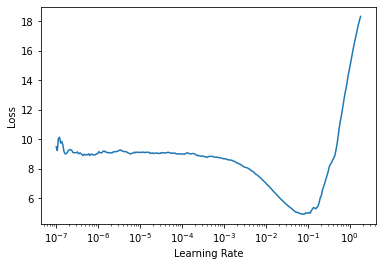

In [27]:
learn.lr_find(num_it=300)

In [28]:
learn.fit(10, 1e-2,cbs=[CSVLogger(),SaveModelCallback(monitor='_rmse')])

epoch,train_loss,valid_loss,mse,_rmse,pearsonr,r2_score,time
0,5.127880,22.193836,22.193836,4.711033,0.059545,-12.026518,01:18
1,3.166198,2.128343,2.128343,1.458884,0.006413,-0.249216,01:19
2,2.432171,2.679850,2.679850,1.637025,nan,-0.572919,01:19
3,2.061330,1.825929,1.825929,1.351269,nan,-0.071716,01:18
4,1.908947,1.820148,1.820148,1.349128,nan,-0.068323,01:18
5,1.825987,1.722799,1.722799,1.312554,nan,-0.011185,01:19
6,1.901904,1.867002,1.867002,1.366383,-0.226268,-0.095824,01:17
7,1.849740,1.730385,1.730385,1.315441,-0.183529,-0.015638,01:19
8,1.869812,1.769007,1.769007,1.330040,0.110690,-0.038306,01:20
9,1.826283,2.793274,2.793274,1.671309,nan,-0.639493,01:19


Better model found at epoch 0 with pearsonr value: 0.05954522235407967.


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Better model found at epoch 8 with pearsonr value: 0.11068970667762301.


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [29]:
learn.save('fit1')

Path('models/fit1.pth')

In [ ]:
learn.export()